In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
labels_per_class = 'full' # full

### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_MNIST, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_MNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Network architecture

In [8]:
dims = (28,28,1)
n_components= 2

### Test model with just UMAP

In [9]:
from tfumap.semisupervised import find_a_b
from tfumap.umap import convert_distance_to_probability

In [10]:
min_dist = 0.001
_a, _b = find_a_b(min_dist)
_a, _b 

(<tf.Tensor: shape=(), dtype=float32, numpy=1.9290735>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.79150456>)

##### build iterator

In [11]:
from tfumap.semisupervised import build_fuzzy_simplicial_set
from tfumap.umap import compute_cross_entropy, get_graph_elements

In [12]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    #y=Y_masked,
    n_neighbors=n_neighbors,
)

In [13]:
umap_graph.nnz

1030704

In [14]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size =  60000

In [15]:
max_sample_repeats_per_epoch = 25
# set the maximum number of times each edge should be repeated per epoch
epochs_per_sample = np.clip(
    (weight / np.max(weight)) * max_sample_repeats_per_epoch,
    1,
    max_sample_repeats_per_epoch,
).astype("int")

In [16]:
edges_to_exp, edges_from_exp = (
        np.repeat(head, epochs_per_sample.astype("int")),
       np.repeat(tail, epochs_per_sample.astype("int")),
)
n_batches = int(len(edges_to_exp) / batch_size)
print(n_batches)
shuffle_mask = np.random.permutation(range(len(edges_to_exp)))[
            : n_batches * batch_size
        ]
edges_to_exp = edges_to_exp[shuffle_mask]
edges_from_exp = edges_from_exp[shuffle_mask]

128


In [17]:
ef = np.reshape(edges_from_exp, (n_batches, batch_size))
et = np.reshape(edges_to_exp, (n_batches, batch_size))
edge_iter = tf.data.Dataset.from_tensor_slices(((et, ef), tf.zeros_like(et)))

In [18]:
negative_sample_rate = 5

In [19]:
def gather_X(edge_to, edge_from):
    return (tf.gather(X_train, edge_to), tf.gather(X_train, edge_from)), 0

In [20]:
for i in tqdm(edge_iter):
    continue

In [21]:
def make_gen_callable(edges_to_exp, edges_from_exp, batch_size):
    def edge_generator():
        batches_remaining = -1

        while True:
            if batches_remaining == -1:
                # shuffle
                shuffle_mask = np.random.permutation(range(len(edges_to_exp)))[
                    : n_batches * batch_size
                ]
                et = np.reshape(edges_to_exp[shuffle_mask], (n_batches, batch_size))
                ef = np.reshape(edges_from_exp[shuffle_mask], (n_batches, batch_size))
                batches_remaining = len(ef)
            batches_remaining -= 1
            yield (tf.expand_dims(et[batches_remaining],-1), tf.expand_dims(ef[batches_remaining],-1)), tf.zeros(batch_size, dtype=tf.int32)
    return edge_generator

In [22]:
def make_gen_callable(edges_to_exp, edges_from_exp, batch_size):
    def edge_generator():
        # shuffle
        shuffle_mask = np.random.permutation(range(len(edges_to_exp)))[
            : n_batches * batch_size
        ]
        et = np.reshape(edges_to_exp[shuffle_mask], (n_batches, batch_size))
        ef = np.reshape(edges_from_exp[shuffle_mask], (n_batches, batch_size))
        for eti, efi in zip(et, ef):
            yield (tf.expand_dims(eti,-1), tf.expand_dims(efi,-1)), tf.zeros(batch_size, dtype=tf.int32)
    return edge_generator

In [23]:
gen = make_gen_callable(edges_to_exp, edges_from_exp, batch_size)

In [40]:
edge_iter = tf.data.Dataset.from_generator(gen, ((tf.int32, tf.int32), tf.int32))
edge_iter = edge_iter.prefetch(200)

In [25]:
(a,b),c = next(iter(edge_iter))

In [26]:
for i in tqdm(edge_iter):
    continue

In [49]:
len(edges_to_exp)

7680000

In [48]:
edges_to_exp

array([33589,  3941, 32215, ...,  7590, 26058,  7119], dtype=int32)

### initialize embedding

In [27]:
from umap.spectral import spectral_layout

from sklearn.utils import check_random_state

random_state = check_random_state(None)
metric = "euclidean"
_metric_kwds = {}
def init_embedding_from_graph(_raw_data, graph, n_components, random_state, metric, _metric_kwds, init="spectral"):
        """ Initialize embedding using graph. This is for direct embeddings. 

        Parameters
        ----------
        init : str, optional
            Type of initialization to use. Either random, or spectral, by default "spectral"

        Returns
        -------
        embedding : np.array
            the initialized embedding
        """
        if isinstance(init, str) and init == "random":
            embedding = random_state.uniform(
                low=-10.0, high=10.0, size=(graph.shape[0], n_components)
            ).astype(np.float32)
        elif isinstance(init, str) and init == "spectral":
            # We add a little noise to avoid local minima for optimization to come

            initialisation = spectral_layout(
                _raw_data,
                graph,
                n_components,
                random_state,
                metric=metric,
                metric_kwds=_metric_kwds,
            )
            expansion = 10.0 / np.abs(initialisation).max()
            embedding = (initialisation * expansion).astype(
                np.float32
            ) + random_state.normal(
                scale=0.0001, size=[graph.shape[0], n_components]
            ).astype(
                np.float32
            )

        else:
            init_data = np.array(init)
            if len(init_data.shape) == 2:
                if np.unique(init_data, axis=0).shape[0] < init_data.shape[0]:
                    tree = KDTree(init_data)
                    dist, ind = tree.query(init_data, k=2)
                    nndist = np.mean(dist[:, 1])
                    embedding = init_data + random_state.normal(
                        scale=0.001 * nndist, size=init_data.shape
                    ).astype(np.float32)
                else:
                    embedding = init_data

        return embedding

In [28]:
embedding = init_embedding_from_graph(X_train, graph, n_components, random_state, metric, _metric_kwds, init="spectral")

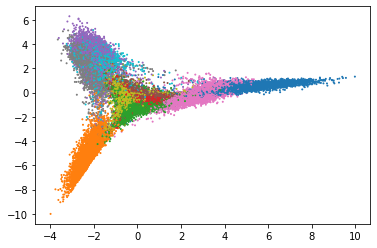

In [29]:
plt.scatter(embedding[:,0], embedding[:,1], c=Y_train, s=1, cmap=plt.cm.tab10)

#### Build network

In [30]:
def umap_loss(batch_size, negative_sample_rate, _a, _b, repulsion_strength = 1.0):
    @tf.function
    def loss(placeholder_y, embed_to_from):
        # split out to/from
        embedding_to, embedding_from = tf.split(embed_to_from, num_or_size_splits=2, axis=1)

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, _a, _b
        )
        
        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)],
            axis=0,
        )
                
        # compute cross entropy
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=repulsion_strength,
        )
        return tf.reduce_mean(ce_loss)

    return loss

In [31]:
from tensorflow.keras.layers import Input

In [32]:
n_data = len(X_train)
embedding_layer = tf.keras.layers.Embedding(n_data, n_components, input_length=1)
embedding_layer.build(input_shape=(1,)) # the input_shape here has no effect in the build function
embedding_layer.set_weights([embedding])
encoder = tf.keras.Sequential([
    embedding_layer
])

In [42]:
initial_learning_rate = 1.0
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate, decay_steps=1000, end_learning_rate=0.0, power=1.0,
    cycle=False, name=None
)
#opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule, clipvalue = 4)
opt = tf.keras.optimizers.Adadelta(learning_rate=50, clipvalue = 4)
#opt = tf.keras.optimizers.Adam(learning_rate=0.1, clipvalue = 4)
#opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule, clipvalue = 4, momentum=0.9)
#opt = tf.keras.optimizers.Adadelta(50, clipvalue = 4)

In [43]:
to_x = Input(shape=(1), name = "to_x")
from_x = Input(shape=(1), name = "from_x")

embedding_to = encoder(to_x)[:,-1,:]
embedding_from = encoder(from_x)[:,-1,:]

embedding_to_from = tf.keras.layers.concatenate([embedding_to, embedding_from],axis=1)
#embedding_to_from = tf.concat([embedding_to, embedding_from], axis = 1)
embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name='umap')(embedding_to_from)

model = tf.keras.Model(
    inputs=[to_x, from_x],
    outputs=[embedding_to_from],#[embedding_to_from],
)
model.compile(
    optimizer=opt,
    loss=umap_loss(batch_size, negative_sample_rate, _a, _b)
)
model.inputs, model.outputs

([<tf.Tensor 'to_x_1:0' shape=(None, 1) dtype=float32>,
  <tf.Tensor 'from_x_1:0' shape=(None, 1) dtype=float32>],
 [<tf.Tensor 'umap/umap_1/Identity:0' shape=(None, 4) dtype=float32>])

In [44]:
history = model.fit(
    edge_iter,
    epochs=10,    
    use_multiprocessing=True,
    workers = 10, 
    max_queue_size = 200,
)

Epoch 1/10
128/128 [==============================] - 4s 28ms/step - loss: 0.1499
Epoch 2/10
128/128 [==============================] - 4s 28ms/step - loss: 0.1496
Epoch 3/10
128/128 [==============================] - 4s 28ms/step - loss: 0.1492
Epoch 4/10
128/128 [==============================] - 4s 28ms/step - loss: 0.1489
Epoch 5/10
128/128 [==============================] - 4s 28ms/step - loss: 0.1486
Epoch 6/10
128/128 [==============================] - 4s 28ms/step - loss: 0.1482
Epoch 7/10
128/128 [==============================] - 4s 28ms/step - loss: 0.1479
Epoch 8/10
128/128 [==============================] - 4s 28ms/step - loss: 0.1476
Epoch 9/10
128/128 [==============================] - 4s 28ms/step - loss: 0.1473
Epoch 10/10
128/128 [==============================] - 4s 27ms/step - loss: 0.1471


In [46]:
history = model.fit(
    edge_iter,
    epochs=1000,      
)

Epoch 1/1000
128/128 [==============================] - 4s 29ms/step - loss: 0.1464
Epoch 2/1000
128/128 [==============================] - 4s 30ms/step - loss: 0.1462
Epoch 3/1000
128/128 [==============================] - 4s 27ms/step - loss: 0.1459
Epoch 4/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1456
Epoch 5/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1453
Epoch 6/1000
128/128 [==============================] - 4s 27ms/step - loss: 0.1450
Epoch 7/1000
128/128 [==============================] - 4s 27ms/step - loss: 0.1448
Epoch 8/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1446
Epoch 9/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1443
Epoch 10/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1440
Epoch 11/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1438
Epoch 12/1000
128/128 [==============================] - 4s 28ms/step - lo

128/128 [==============================] - 4s 29ms/step - loss: 0.1247
Epoch 193/1000
128/128 [==============================] - 4s 29ms/step - loss: 0.1246
Epoch 194/1000
128/128 [==============================] - 4s 29ms/step - loss: 0.1246
Epoch 195/1000
128/128 [==============================] - 4s 29ms/step - loss: 0.1246
Epoch 196/1000
128/128 [==============================] - 4s 29ms/step - loss: 0.1245
Epoch 197/1000
128/128 [==============================] - 4s 29ms/step - loss: 0.1245
Epoch 198/1000
128/128 [==============================] - 4s 29ms/step - loss: 0.1244
Epoch 199/1000
128/128 [==============================] - 4s 29ms/step - loss: 0.1243
Epoch 200/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1243
Epoch 201/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1243
Epoch 202/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1242
Epoch 203/1000
128/128 [==============================] - 4s 27ms/ste

128/128 [==============================] - 4s 28ms/step - loss: 0.1175
Epoch 383/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1174
Epoch 384/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1174
Epoch 385/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1174
Epoch 386/1000
128/128 [==============================] - 4s 27ms/step - loss: 0.1173
Epoch 387/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1173
Epoch 388/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1172
Epoch 389/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1172
Epoch 390/1000
128/128 [==============================] - 4s 29ms/step - loss: 0.1172
Epoch 391/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1172
Epoch 392/1000
128/128 [==============================] - 3s 27ms/step - loss: 0.1172
Epoch 393/1000
128/128 [==============================] - 4s 28ms/ste

128/128 [==============================] - 4s 28ms/step - loss: 0.1133
Epoch 573/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1133
Epoch 574/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1134
Epoch 575/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1133
Epoch 576/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1132
Epoch 577/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1132
Epoch 578/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1132
Epoch 579/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1132
Epoch 580/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1132
Epoch 581/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1132
Epoch 582/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1132
Epoch 583/1000
128/128 [==============================] - 4s 28ms/ste

128/128 [==============================] - 4s 28ms/step - loss: 0.1106
Epoch 763/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1106
Epoch 764/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1106
Epoch 765/1000
128/128 [==============================] - 4s 29ms/step - loss: 0.1106
Epoch 766/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1105
Epoch 767/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1106
Epoch 768/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1105
Epoch 769/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1105
Epoch 770/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1105
Epoch 771/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1105
Epoch 772/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1104
Epoch 773/1000
128/128 [==============================] - 3s 27ms/ste

128/128 [==============================] - 4s 28ms/step - loss: 0.1086
Epoch 953/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1086
Epoch 954/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1086
Epoch 955/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1085
Epoch 956/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1086
Epoch 957/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1085
Epoch 958/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1085
Epoch 959/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1085
Epoch 960/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1085
Epoch 961/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1085
Epoch 962/1000
128/128 [==============================] - 4s 28ms/step - loss: 0.1085
Epoch 963/1000
128/128 [==============================] - 4s 29ms/ste

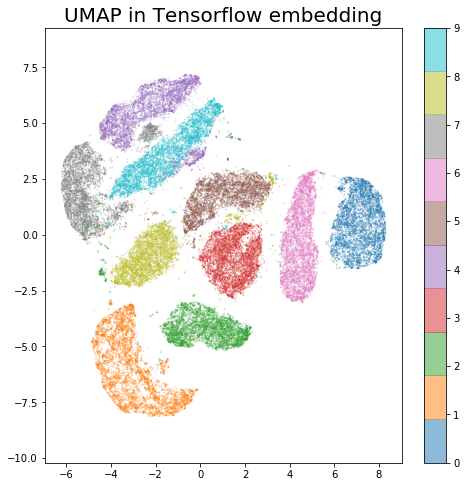

In [47]:
z = encoder(np.arange(len(X_train)))[:,-1,:]

fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

while true
    if i = 0
        i = len(x)
        x = the preprepared thing
        -> in another thread, prepare x
    i -= 1
    yield x[i]

In [ ]:
"""z = encoder(np.arange(len(X_train)))[:,-1,:]

fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);"""